# Tutorial 1.c.2 Conformal Calibration: From any Prediction to Calibrated Probability

In the previous tutorial we used conformal (interval) prediction to convert any prediction type into intervals with correct coverage. In this tutorial we will take this a step further and convert any prediction type into distributions that are calibrated. Recall that a distribution prediction can be represented as a random variable $F$ that takes values in the set of cumulative distribution functions $F: \mathbb{R} \to [0, 1]$, and we say that the distribution prediction is calibrated if 
\begin{align}
\mathrm{Pr}[F(Y) \leq c] = \Pr[Y \leq F^{-1}(c)] = c, \forall c  \label{eq:calibration} \tag{1} 
\end{align}
where $Y$ is the label. In this formula, $F$ should be interpreted as a random variable (i.e. a randomly sampled prediction) and $Y$ is the associated true label of the randomly sampled prediction. Intuitively, $F^{-1}(c)$ is the $c$-th quantile of the predicted CDF, and $Y$ is below the $c$-th quantile exactly $c$-proportion of times. 

This is a generalization of what interval prediction in the previous tutorial because distributions contain strictly more information than intervals. As shown in (cite), if $F$ is a calibrated distribution prediction, then the interval $[F^{-1}(c/2), F^{-1}(1-c/2)]$ is an interval prediction with correct $c$-coverage. Formally if Eq.\eqref{eq:calibration} is true then
\begin{align}
\Pr \left[ Y \in [F^{-1}(c/2), F^{-1}(1-c/2)] \right] = c
\end{align} 

Conformal calibration (cite) is a method of converting any prediction type into calibrated probabilities. The intuition behind the algorithm is very similar to conformal (interval) prediction in the previous tutorial. In this tutorial we will not go into details of how conformal calibration works, but how to implement it in torchuq. The main workhorse for conformal calibration is the class ``torchuq.transform.conformal.ConformalCalibrator``. We first import it the class, as well as some test prediction data (same as tutorial 1.a). 

In [3]:
from matplotlib import pyplot as plt
import torch 

import sys
sys.path.append('../..')   # Include the directory that contains the torchuq package
from torchuq.transform.conformal import ConformalCalibrator

reader = torch.load('pretrained/boston_pretrained.tar')  # Load the pretrained predictions
val_pred = reader['predictions_quantile'][:50]
val_labels = reader['labels'][:50]
test_pred = reader['predictions_quantile'][50:]
test_labels = reader['labels'][50:]

``ConformalCalibrator`` has exactly the same interface as ``ConformalIntervalPredictor`` in the previous tutorial. Specifically, there are three functions that you need to know 

1. Constructor: ``calibrator = ConformalCalibrator(input_type='quantile', interpolation='linear')``. there is only one required argument, which is the prediction type, it is one of the types introduced in tutorial 1.a.

2. Train: ``ConformalCalibrator.train(val_preds, val_labels)`` trains the conformal predictor based on validation predictions and validation labels

3. Test: ``test_distribution = ConformalCalibrator.__call__(test_preds)`` outputs the calibrated distribution predictions. 

In [22]:
# ConformalCalibrator takes an argument called interpolation. For details of what this option means please see (cite). 
# In general, use 'random' if you want better calibration, use 'naf' if you want better log likelihood (but worse numerical stability and computation speed)
# Use 'linear' for a good trade-off (default option) 
calibrator = ConformalCalibrator(input_type='quantile', interpolation='random')   
calibrator.train(val_pred, val_labels)
test_distribution = calibrator(test_pred)

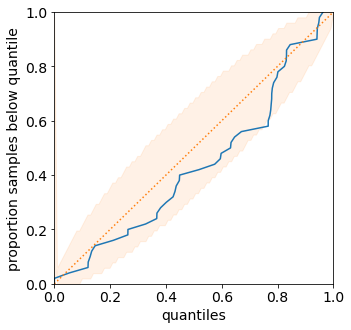

In [23]:
from torchuq.evaluate import distribution, interval
distribution.plot_reliability_diagram(test_distribution, test_labels);

We can also convert the distribution to intervals with the function ``torchuq.transform.direct.distribution_to_interval``, which makes the simplest transformation introduced in the beginning of this tutorial (i.e. mapping CDF $F$ to interval $F^{-1}(c/2), F^{-1}(1-c/2)$. We visualize the intervals and demonstrate that these intervals appear to have the correct coverage. 

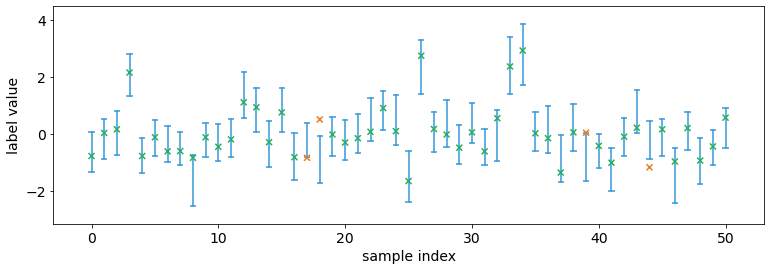

In [24]:
from torchuq.transform.direct import distribution_to_interval 

converted_interval = distribution_to_interval(test_distribution, confidence=0.95)
interval.plot_interval_sequence(converted_interval, test_labels) 

## Online Calibration 

Similar to conformal interval prediction, we can also use conformal calibration in the online setup. The usage is almost identical to the previous tutorial. Here is an example. 

At each step, we only make a single distribution prediction (i.e. a batch of distribution prediction with ``batch_size=1``). However for visualization purposes we will want to concatenate them into a single batch of distribution predictions (because all torchuq visualziation functions take as input a single batch of distribution prediction). Pytorch does not provide this function, so for convenience we implement concatenation in torchuq with the class ``ConcatDistribution``. 

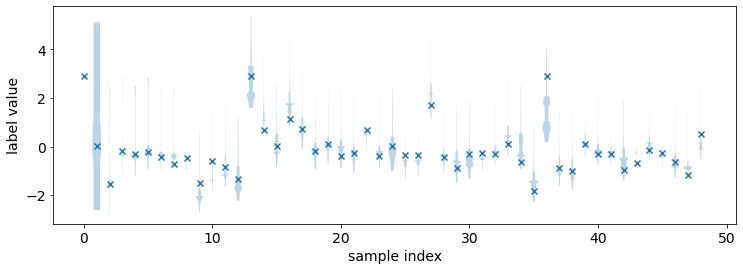

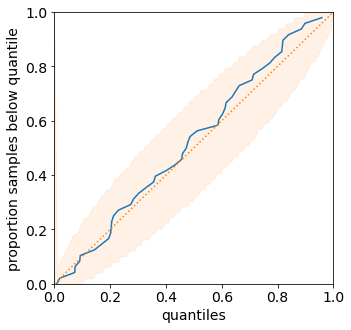

In [32]:
from torchuq.transform.basic import ConcatDistribution

calibrator = ConformalCalibrator(input_type='quantile')

val_preds = reader['predictions_quantile'][:50]
val_labels = reader['labels'][:50]   # Load the true label (i.e. the ground truth housing prices)

def simulate_online(calibrator):
    # There needs to be at least 1 data point before making any prediction 
    calibrator.train(val_preds[0:1], val_labels[0:1])

    prediction_history = []
    for t in range(1, 50): 
        test_distribution = calibrator(val_preds[t:t+1])  # Make a prediction for the new time step
        
        # If this weren't a simulation, you would do something with the prediction before the label is observed 
        
        calibrator.update(val_preds[t:t+1], val_labels[t:t+1])   # Update the calibrator based on the observed label
        
        prediction_history.append(test_distribution)

    # Concat the interval predictions for plotting 
    prediction_history = ConcatDistribution(prediction_history)
    return prediction_history

prediction_history = simulate_online(calibrator)
distribution.plot_density_sequence(prediction_history, val_labels[1:50], smooth_bw=10)   # Smooth the resulting CDF a bit for better visual appeal
distribution.plot_reliability_diagram(prediction_history, val_labels[1:50]);

Observe that we get much better calibration in the online setup. The reason for this is very interesting and sutble. We will not go into detail of why this is and refer interested readers to (cite). 